In [18]:
import theano
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D, ZeroPadding1D
from keras.optimizers import SGD
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
feat_0_path='data/mon_exp/feat/0'
feat_1_path='data/mon_exp/feat/1'
#max_feat_count=7500

def get_feats(feat_0_path, feat_1_path, max_feat_count):
    feats_0_list = []
    for fil in os.listdir(feat_0_path):
        feats = []
        with open(os.path.join(feat_0_path, fil)) as f:
            feats = f.readlines()
            feats = [float(line) for line in feats]
        feats = np.array(feats)
        feats1 = np.zeros(max_feat_count)
        length = min(len(feats), max_feat_count)
        feats1[:length] = feats[:length]
        #print len(feats)
        feats_0_list.append(feats1)

    feats_1_list = []
    for fil in os.listdir(feat_1_path):
        feats = []
        with open(os.path.join(feat_1_path, fil)) as f:
            feats = f.readlines()
            feats = [float(line) for line in feats]
        feats = np.array(feats)
        feats1 = np.zeros(max_feat_count)
        length = min(len(feats), max_feat_count)
        feats1[:length] = feats[:length]
        #print len(feats1)
        feats_1_list.append(feats1)
    return feats_0_list, feats_1_list  

In [3]:
#num_test=100
def split(num_test, feats_0_list, feats_1_list):
    f0 = np.array(feats_0_list)
    f1 = np.array(feats_1_list)
    f1 = np.repeat(f1, 9, axis=0)
    print f0.shape
    print f1.shape
    f0_tr = f0[:-num_test, :]
    f1_tr = f1[:-num_test, :]
    print f0_tr.shape
    print f1_tr.shape
    f0_ts = f0[-num_test:, :]
    f1_ts = f1[-num_test:, :]
    print f0_ts.shape
    print f1_ts.shape
    return f0_tr, f1_tr, f0_ts, f1_ts

In [15]:
def append_labels(f0_tr, f1_tr, f0_ts, f1_ts):
    lab_0_tr = np.zeros((f0_tr.shape[0],2))
    lab_1_tr = np.zeros((f1_tr.shape[0],2))
    lab_0_ts = np.zeros((f0_ts.shape[0],2))
    lab_1_ts = np.zeros((f1_ts.shape[0],2))

    lab_0_tr[:,0] = 1
    lab_1_tr[:,1] = 1
    lab_0_ts[:,0] = 1
    lab_1_ts[:,1] = 1

    print lab_0_tr.shape
    x_0_tr = np.append(f0_tr,lab_0_tr, axis=1)
    x_1_tr = np.append(f1_tr, lab_1_tr, axis=1)
    print x_0_tr.shape
    x_0_ts = np.append(f0_ts, lab_0_ts, axis=1)
    x_1_ts = np.append(f1_ts, lab_1_ts, axis=1)
    return x_0_tr, lab_0_tr, x_1_tr, lab_1_tr, x_0_ts, lab_0_ts, x_1_ts, lab_1_ts

In [16]:
def get_shuffled( max_feat_count, x_0_tr, lab_0_tr, x_1_tr, lab_1_tr, x_0_ts, lab_0_ts, x_1_ts, lab_1_ts):
    x_tr = np.vstack([x_0_tr, x_1_tr])
    print x_tr.shape
    x_ts = np.vstack([x_0_ts, x_1_ts])
    np.random.shuffle(x_tr)
    np.random.shuffle(x_ts)
    X_tr = x_tr[:, 0:max_feat_count]
    y_tr = x_tr[:, max_feat_count:]
    X_ts = x_ts[:, 0:max_feat_count]
    y_ts = x_ts[:, max_feat_count:]
    print X_tr.shape
    print y_tr.shape
    print X_ts.shape
    print y_ts.shape
    return X_tr, y_tr, X_ts, y_ts

In [6]:
def VGG_16(max_len, weights_path=None):
    model = Sequential()
    model.add(ZeroPadding1D((1,1),input_shape=(1, max_len)))
    model.add(Conv1D(256, (3, ), activation='relu'))
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(256, (3, ), activation='relu'))
    #model.add(MaxPooling2D((2,2), strides=(2,2)))
    print model.output_shape
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(128, (3, ), activation='relu'))
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(128, (3, ), activation='relu'))
    #print "Before max pool %s" %str(model.output_shape)
    #model.add(MaxPooling1D(pool_size=1, strides=1))
    #print model.output_shape
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(64, (3, ), activation='relu'))
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(64, (3, ), activation='relu'))
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(64, (3, ), activation='relu'))
    #print model.output_shape
    #model.add(MaxPooling1D(2, strides=2))
    #print model.output_shape
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(32, (3, ), activation='relu'))
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(32, (3, ), activation='relu'))
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(32, (3, ), activation='relu'))
    #model.add(MaxPooling1D(2, strides=2))
    #print model.output_shape
    '''
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    '''
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    '''model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='relu'))
    model.add(Dropout(0.5))'''
    
    
    if weights_path:
        model.load_weights(weights_path)

    return model


In [7]:
print theano.__version__
import keras.backend as K
K.set_image_dim_ordering('th')
print K.image_dim_ordering()
input_shape=(1,max_feat_count)
print all(input_shape[1:])
from theano import ifelse
print theano.ifelse.ifelse

0.10.0dev1.dev-d51233517debf3a1231a33058d65e8f969db923d
th


NameError: name 'max_feat_count' is not defined

In [8]:
def get_model(max_feat_count, vgg = False):
    if not vgg:
        model = Sequential()
        #model.add(Dense(2, activation='relu', input_dim=max_feat_count))
        #model.add(Dense(2, activation='softmax' ))
        model.add(Dense(2, activation='softmax',input_dim=max_feat_count ))
    else:
        model = VGG_16(max_feat_count)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']  )
    return model

In [9]:
def reshape(X_tr, X_ts, vgg = False):
    if vgg:
        X_tr = X_tr.reshape(X_tr.shape[0], 1, X_tr.shape[1])
        X_ts = X_ts.reshape(X_ts.shape[0], 1, X_ts.shape[1])
    return X_tr, X_ts

In [10]:
def train_model(model, X_tr, y_tr, batch_siz=32, epoch=10):
    return model.fit(X_tr, y_tr, batch_size=batch_siz, epochs=epoch)

In [11]:
def test_model(model, X_ts, y_ts):
    return model.evaluate(X_ts, y_ts, batch_size=X_ts.shape[0])

In [89]:
print X_tr.shape
print y_tr.shape
print model.summary()

(5495, 1, 7000)
(5495, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 2)                 14002     
Total params: 14,002
Trainable params: 14,002
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
def run(feat_0_path, feat_1_path, max_feat_count, num_test, vgg=False, batch_size=32, epochs=10):
    X_tr, y_tr, X_ts, y_ts = get_shuffled( max_feat_count, *append_labels( *split( num_test, \
                                                        *get_feats(feat_0_path, feat_1_path, max_feat_count) ) ) )
    X_tr, X_ts = reshape(X_tr, X_ts, vgg)
    model = get_model(max_feat_count, vgg)
    h_tr = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs)
    l_tr = h_tr.history['loss'][-1]
    a_tr = h_tr.history['acc'][-1]
    print l_tr
    print a_tr
    h_ts = model.evaluate(X_ts, y_ts, batch_size=X_ts.shape[0])
    l_ts = h_ts[0]
    a_ts = h_ts[1]
    print l_ts
    print a_ts
    return l_tr, a_tr, l_ts, a_ts

In [13]:
def batch(feat_0_path, feat_1_path, num_test, start_feat, end_feat, step_feat=100):
    tr_loss = []; tr_acc = []; ts_loss = []; ts_acc = []
    for feat in xrange(start_feat, end_feat, step_feat):
        print "Starting run - max_feat_count = %d"%feat
        l_tr, a_tr, l_ts, a_ts = run(feat_0_path, feat_1_path, feat, num_test)
        tr_loss.append(l_tr)
        tr_acc.append(a_tr)
        ts_loss.append(l_ts)
        ts_acc.append(a_ts)
    return tr_loss, tr_acc, ts_loss, ts_acc    

In [17]:
feat_0_path='data/mon_exp/feat/0'
feat_1_path='data/mon_exp/feat/1'
num_test=100
start_feat = 100
end_feat = 10000
step_feat = 100
tr_loss, tr_acc, ts_loss, ts_acc = batch(feat_0_path, feat_1_path, num_test, start_feat, end_feat, step_feat)

Starting run - max_feat_count = 100
(2815, 100)
(2880, 100)
(2715, 100)
(2780, 100)
(100, 100)
(100, 100)
(2715, 2)
(2715, 102)
(5495, 102)
(5495, 100)
(5495, 2)
(200, 100)
(200, 2)
Epoch 1/10
5495/5495 [==============================] - 0s - loss: 0.7616 - acc: 0.5634     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.6387 - acc: 0.6433     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.5908 - acc: 0.6921     
Epoch 4/10
5495/5495 [==============================] - 0s - loss: 0.5712 - acc: 0.7048     
Epoch 5/10
5495/5495 [==============================] - 0s - loss: 0.5613 - acc: 0.7090     
Epoch 6/10
5495/5495 [==============================] - 0s - loss: 0.5556 - acc: 0.7190     
Epoch 7/10
5495/5495 [==============================] - 0s - loss: 0.5515 - acc: 0.7167     
Epoch 8/10
5495/5495 [==============================] - 0s - loss: 0.5505 - acc: 0.7143     
Epoch 9/10
5495/5495 [==============================] - 0s - loss: 0.5491 

5495/5495 [==============================] - 0s - loss: 0.3652 - acc: 0.8204     
Epoch 10/10
5495/5495 [==============================] - 0s - loss: 0.3615 - acc: 0.8249     
0.361542493595
0.824931756142
200/200 [==============================] - 0s
0.552983978168
0.7
Starting run - max_feat_count = 800
(2815, 800)
(2880, 800)
(2715, 800)
(2780, 800)
(100, 800)
(100, 800)
(2715, 2)
(2715, 802)
(5495, 802)
(5495, 800)
(5495, 2)
(200, 800)
(200, 2)
Epoch 1/10
5495/5495 [==============================] - 0s - loss: 0.5941 - acc: 0.6728     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.4590 - acc: 0.7802     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.4161 - acc: 0.7893     
Epoch 4/10
5495/5495 [==============================] - 0s - loss: 0.3952 - acc: 0.8060     
Epoch 5/10
5495/5495 [==============================] - 0s - loss: 0.3817 - acc: 0.8129     
Epoch 6/10
5495/5495 [==============================] - 0s - loss: 0.3726 - acc: 0

5495/5495 [==============================] - 0s - loss: 0.3632 - acc: 0.8191     
Epoch 6/10
5495/5495 [==============================] - 0s - loss: 0.3564 - acc: 0.8229     
Epoch 7/10
5495/5495 [==============================] - 0s - loss: 0.3522 - acc: 0.8215     
Epoch 8/10
5495/5495 [==============================] - 0s - loss: 0.3485 - acc: 0.8237     
Epoch 9/10
5495/5495 [==============================] - 0s - loss: 0.3459 - acc: 0.8251     
Epoch 10/10
5495/5495 [==============================] - 0s - loss: 0.3439 - acc: 0.8258     
0.343918793633
0.825841674249
200/200 [==============================] - 0s
0.50834842222
0.735
Starting run - max_feat_count = 1500
(2815, 1500)
(2880, 1500)
(2715, 1500)
(2780, 1500)
(100, 1500)
(100, 1500)
(2715, 2)
(2715, 1502)
(5495, 1502)
(5495, 1500)
(5495, 2)
(200, 1500)
(200, 2)
Epoch 1/10
5495/5495 [==============================] - 0s - loss: 0.5490 - acc: 0.7145     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.4

5495/5495 [==============================] - 0s - loss: 0.5648 - acc: 0.6928     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.4188 - acc: 0.7843     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.3825 - acc: 0.8078     
Epoch 4/10
5495/5495 [==============================] - 0s - loss: 0.3666 - acc: 0.8186     
Epoch 5/10
5495/5495 [==============================] - 0s - loss: 0.3580 - acc: 0.8198     
Epoch 6/10
5495/5495 [==============================] - 0s - loss: 0.3526 - acc: 0.8218     
Epoch 7/10
5495/5495 [==============================] - 0s - loss: 0.3489 - acc: 0.8240     
Epoch 8/10
5495/5495 [==============================] - 0s - loss: 0.3466 - acc: 0.8238     
Epoch 9/10
5495/5495 [==============================] - 0s - loss: 0.3441 - acc: 0.8253     
Epoch 10/10
5495/5495 [==============================] - 0s - loss: 0.3425 - acc: 0.8295     
0.342493836273
0.829481346679
200/200 [==============================] - 0s
0.48

5495/5495 [==============================] - 0s - loss: 0.3418 - acc: 0.8266     
0.341769677285
0.826569608735
200/200 [==============================] - 0s
0.498421213933
0.73
Starting run - max_feat_count = 2800
(2815, 2800)
(2880, 2800)
(2715, 2800)
(2780, 2800)
(100, 2800)
(100, 2800)
(2715, 2)
(2715, 2802)
(5495, 2802)
(5495, 2800)
(5495, 2)
(200, 2800)
(200, 2)
Epoch 1/10
5495/5495 [==============================] - 0s - loss: 0.5449 - acc: 0.7039     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.4060 - acc: 0.7962     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.3748 - acc: 0.8102     
Epoch 4/10
5495/5495 [==============================] - 0s - loss: 0.3633 - acc: 0.8151     
Epoch 5/10
5495/5495 [==============================] - 0s - loss: 0.3564 - acc: 0.8191     
Epoch 6/10
5495/5495 [==============================] - 0s - loss: 0.3515 - acc: 0.8227     
Epoch 7/10
5495/5495 [==============================] - 0s - loss: 0.34

5495/5495 [==============================] - 0s - loss: 0.3509 - acc: 0.8231     
Epoch 7/10
5495/5495 [==============================] - 0s - loss: 0.3474 - acc: 0.8266     
Epoch 8/10
5495/5495 [==============================] - 0s - loss: 0.3451 - acc: 0.8278     
Epoch 9/10
5495/5495 [==============================] - 0s - loss: 0.3431 - acc: 0.8264     
Epoch 10/10
5495/5495 [==============================] - 0s - loss: 0.3417 - acc: 0.8326     
0.341659254678
0.832575068244
200/200 [==============================] - 0s
0.501009804127
0.735
Starting run - max_feat_count = 3500
(2815, 3500)
(2880, 3500)
(2715, 3500)
(2780, 3500)
(100, 3500)
(100, 3500)
(2715, 2)
(2715, 3502)
(5495, 3502)
(5495, 3500)
(5495, 2)
(200, 3500)
(200, 2)
Epoch 1/10
5495/5495 [==============================] - 0s - loss: 0.5338 - acc: 0.7176     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.4007 - acc: 0.7911     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.

5495/5495 [==============================] - 0s - loss: 0.5475 - acc: 0.7183     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.4023 - acc: 0.7847     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.3731 - acc: 0.8078     
Epoch 4/10
5495/5495 [==============================] - 0s - loss: 0.3619 - acc: 0.8220     
Epoch 5/10
5495/5495 [==============================] - 0s - loss: 0.3547 - acc: 0.8207     
Epoch 6/10
5495/5495 [==============================] - 0s - loss: 0.3501 - acc: 0.8233     
Epoch 7/10
5495/5495 [==============================] - 0s - loss: 0.3472 - acc: 0.8237     
Epoch 8/10
5495/5495 [==============================] - 0s - loss: 0.3446 - acc: 0.8275     
Epoch 9/10
5495/5495 [==============================] - 0s - loss: 0.3428 - acc: 0.8289     
Epoch 10/10
5495/5495 [==============================] - 0s - loss: 0.3410 - acc: 0.8297     
0.341009458328
0.8296633303
200/200 [==============================] - 0s
0.5263

5495/5495 [==============================] - 0s - loss: 0.3409 - acc: 0.8260     
0.34091457442
0.826023657871
200/200 [==============================] - 0s
0.526349198934
0.74
Starting run - max_feat_count = 4800
(2815, 4800)
(2880, 4800)
(2715, 4800)
(2780, 4800)
(100, 4800)
(100, 4800)
(2715, 2)
(2715, 4802)
(5495, 4802)
(5495, 4800)
(5495, 2)
(200, 4800)
(200, 2)
Epoch 1/10
5495/5495 [==============================] - 0s - loss: 0.5115 - acc: 0.7265     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.4002 - acc: 0.7907     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.3721 - acc: 0.8109     
Epoch 4/10
5495/5495 [==============================] - 0s - loss: 0.3604 - acc: 0.8195     
Epoch 5/10
5495/5495 [==============================] - 0s - loss: 0.3536 - acc: 0.8218     
Epoch 6/10
5495/5495 [==============================] - 0s - loss: 0.3493 - acc: 0.8246     
Epoch 7/10
5495/5495 [==============================] - 0s - loss: 0.346

5495/5495 [==============================] - 0s - loss: 0.3504 - acc: 0.8213     
Epoch 7/10
5495/5495 [==============================] - 0s - loss: 0.3470 - acc: 0.8229     
Epoch 8/10
5495/5495 [==============================] - 0s - loss: 0.3444 - acc: 0.8240     
Epoch 9/10
5495/5495 [==============================] - 0s - loss: 0.3429 - acc: 0.8253     
Epoch 10/10
5495/5495 [==============================] - 0s - loss: 0.3414 - acc: 0.8271     
0.341368365485
0.8271155596
200/200 [==============================] - 0s
0.524407994874
0.735
Starting run - max_feat_count = 5500
(2815, 5500)
(2880, 5500)
(2715, 5500)
(2780, 5500)
(100, 5500)
(100, 5500)
(2715, 2)
(2715, 5502)
(5495, 5502)
(5495, 5500)
(5495, 2)
(200, 5500)
(200, 2)
Epoch 1/10
5495/5495 [==============================] - 0s - loss: 0.5424 - acc: 0.7201     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.4005 - acc: 0.7945     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.37

5495/5495 [==============================] - 0s - loss: 0.3968 - acc: 0.7918     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.3706 - acc: 0.8109     
Epoch 4/10
5495/5495 [==============================] - 0s - loss: 0.3594 - acc: 0.8197     
Epoch 5/10
5495/5495 [==============================] - 0s - loss: 0.3532 - acc: 0.8202     
Epoch 6/10
5495/5495 [==============================] - 0s - loss: 0.3490 - acc: 0.8233     
Epoch 7/10
5495/5495 [==============================] - 0s - loss: 0.3465 - acc: 0.8249     
Epoch 8/10
5495/5495 [==============================] - 0s - loss: 0.3441 - acc: 0.8273     
Epoch 9/10
5495/5495 [==============================] - 0s - loss: 0.3423 - acc: 0.8246     
Epoch 10/10
5495/5495 [==============================] - 0s - loss: 0.3411 - acc: 0.8282     
0.341126007804
0.828207461328
200/200 [==============================] - 0s
0.521606419665
0.74
Starting run - max_feat_count = 6200
(2815, 6200)
(2880, 6200)
(2715, 6200)
(

200/200 [==============================] - 0s
0.518375355677
0.74
Starting run - max_feat_count = 6800
(2815, 6800)
(2880, 6800)
(2715, 6800)
(2780, 6800)
(100, 6800)
(100, 6800)
(2715, 2)
(2715, 6802)
(5495, 6802)
(5495, 6800)
(5495, 2)
(200, 6800)
(200, 2)
Epoch 1/10
5495/5495 [==============================] - 0s - loss: 0.5438 - acc: 0.7194     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.3948 - acc: 0.7996     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.3712 - acc: 0.8084     
Epoch 4/10
5495/5495 [==============================] - 0s - loss: 0.3597 - acc: 0.8202     
Epoch 5/10
5495/5495 [==============================] - 0s - loss: 0.3532 - acc: 0.8222     
Epoch 6/10
5495/5495 [==============================] - 0s - loss: 0.3492 - acc: 0.8220     
Epoch 7/10
5495/5495 [==============================] - 0s - loss: 0.3463 - acc: 0.8247     
Epoch 8/10
5495/5495 [==============================] - 0s - loss: 0.3444 - acc: 0.8237   

5495/5495 [==============================] - 0s - loss: 0.3464 - acc: 0.8249     
Epoch 8/10
5495/5495 [==============================] - 0s - loss: 0.3442 - acc: 0.8264     
Epoch 9/10
5495/5495 [==============================] - 0s - loss: 0.3423 - acc: 0.8266     - ETA: 0s - loss: 0.3328 - acc: 0.8
Epoch 10/10
5495/5495 [==============================] - 0s - loss: 0.3408 - acc: 0.8311     
0.340840702761
0.831119199272
200/200 [==============================] - 0s
0.527112937346
0.74
Starting run - max_feat_count = 7500
(2815, 7500)
(2880, 7500)
(2715, 7500)
(2780, 7500)
(100, 7500)
(100, 7500)
(2715, 2)
(2715, 7502)
(5495, 7502)
(5495, 7500)
(5495, 2)
(200, 7500)
(200, 2)
Epoch 1/10
5495/5495 [==============================] - 0s - loss: 0.5259 - acc: 0.7339     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.3933 - acc: 0.7951     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.3695 - acc: 0.8149     
Epoch 4/10
5495/5495 [=============

5495/5495 [==============================] - 0s - loss: 0.3974 - acc: 0.8025     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.3735 - acc: 0.8109     
Epoch 4/10
5495/5495 [==============================] - 0s - loss: 0.3611 - acc: 0.8206     
Epoch 5/10
5495/5495 [==============================] - 0s - loss: 0.3536 - acc: 0.8226     
Epoch 6/10
5495/5495 [==============================] - 0s - loss: 0.3498 - acc: 0.8249     
Epoch 7/10
5495/5495 [==============================] - 0s - loss: 0.3467 - acc: 0.8269     
Epoch 8/10
5495/5495 [==============================] - 0s - loss: 0.3446 - acc: 0.8291     
Epoch 9/10
5495/5495 [==============================] - 0s - loss: 0.3424 - acc: 0.8304     
Epoch 10/10
5495/5495 [==============================] - 0s - loss: 0.3411 - acc: 0.8300     
0.341063796442
0.830027297543
200/200 [==============================] - 0s
0.525005222014
0.74
Starting run - max_feat_count = 8200
(2815, 8200)
(2880, 8200)
(2715, 8200)
(

200/200 [==============================] - 0s
0.547302884231
0.735
Starting run - max_feat_count = 8800
(2815, 8800)
(2880, 8800)
(2715, 8800)
(2780, 8800)
(100, 8800)
(100, 8800)
(2715, 2)
(2715, 8802)
(5495, 8802)
(5495, 8800)
(5495, 2)
(200, 8800)
(200, 2)
Epoch 1/10
5495/5495 [==============================] - 0s - loss: 0.5192 - acc: 0.7263     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.3943 - acc: 0.7920     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.3711 - acc: 0.8096     
Epoch 4/10
5495/5495 [==============================] - 0s - loss: 0.3594 - acc: 0.8157     
Epoch 5/10
5495/5495 [==============================] - 0s - loss: 0.3539 - acc: 0.8215     
Epoch 6/10
5495/5495 [==============================] - 0s - loss: 0.3492 - acc: 0.8233     
Epoch 7/10
5495/5495 [==============================] - 0s - loss: 0.3463 - acc: 0.8257     
Epoch 8/10
5495/5495 [==============================] - 0s - loss: 0.3441 - acc: 0.8269  

5495/5495 [==============================] - 0s - loss: 0.3470 - acc: 0.8262     
Epoch 8/10
5495/5495 [==============================] - 0s - loss: 0.3443 - acc: 0.8269     
Epoch 9/10
5495/5495 [==============================] - 0s - loss: 0.3424 - acc: 0.8297     
Epoch 10/10
5495/5495 [==============================] - 0s - loss: 0.3407 - acc: 0.8313     
0.340671527107
0.831301182894
200/200 [==============================] - 0s
0.522249337911
0.74
Starting run - max_feat_count = 9500
(2815, 9500)
(2880, 9500)
(2715, 9500)
(2780, 9500)
(100, 9500)
(100, 9500)
(2715, 2)
(2715, 9502)
(5495, 9502)
(5495, 9500)
(5495, 2)
(200, 9500)
(200, 2)
Epoch 1/10
5495/5495 [==============================] - 0s - loss: 0.6242 - acc: 0.7352     
Epoch 2/10
5495/5495 [==============================] - 0s - loss: 0.5219 - acc: 0.7873     
Epoch 3/10
5495/5495 [==============================] - 0s - loss: 0.5002 - acc: 0.8042     
Epoch 4/10
5495/5495 [==============================] - 0s - loss: 0.4

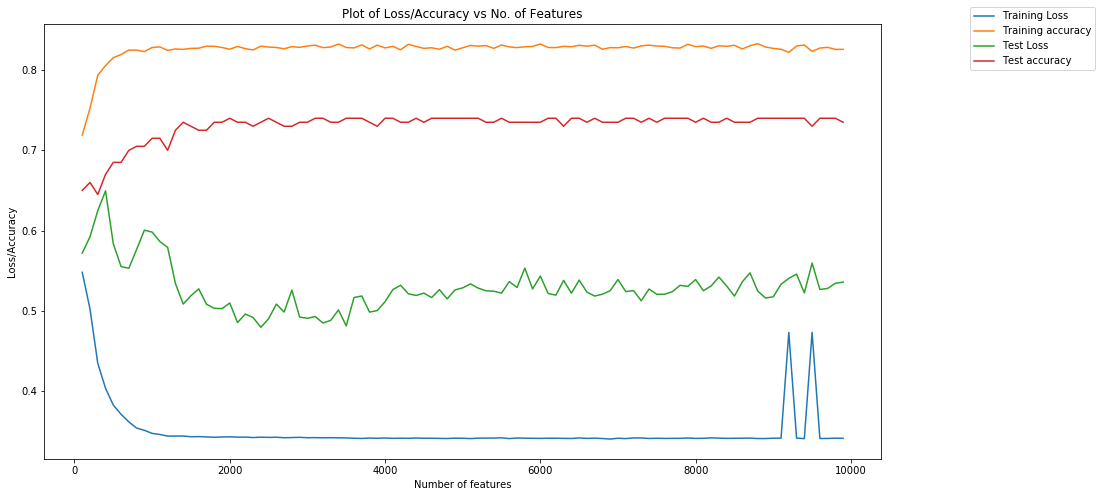

In [38]:
plt.rcParams['figure.figsize'] = (15, 8)

f = np.arange(start_feat, end_feat, step_feat)

#plt.subplot(221)
plt.plot(f, tr_loss, label='Training Loss')

#plt.subplot(222)
plt.plot(f, tr_acc, label='Training accuracy')

#plt.subplot(223)
plt.plot(f, ts_loss, label='Test Loss')

#plt.subplot(224)
plt.plot(f, ts_acc, label='Test accuracy')

plt.legend(bbox_to_anchor=(1.1, 1.05))

plt.xlabel("Number of features")
plt.ylabel("Loss/Accuracy")
plt.title("Plot of Loss/Accuracy vs No. of Features")

plt.show()

In [17]:
print model.predict(X_ts[0:20])

[[  5.69689543e-01   4.30310457e-01]
 [  5.69689543e-01   4.30310457e-01]
 [  6.61957078e-01   3.38042922e-01]
 [  4.54505547e-01   5.45494453e-01]
 [  6.12342503e-01   3.87657497e-01]
 [  9.99999998e-01   1.59369572e-09]
 [  8.09497001e-01   1.90502999e-01]
 [  5.72051439e-01   4.27948561e-01]
 [  6.75542540e-01   3.24457460e-01]
 [  6.30778393e-01   3.69221607e-01]
 [  4.56964257e-01   5.43035743e-01]
 [  5.83463197e-01   4.16536803e-01]
 [  1.31149613e-01   8.68850387e-01]
 [  9.99999824e-01   1.76004363e-07]
 [  6.27069978e-01   3.72930022e-01]
 [  6.79499409e-01   3.20500591e-01]
 [  5.95529672e-01   4.04470328e-01]
 [  7.02956148e-01   2.97043852e-01]
 [  8.09497001e-01   1.90502999e-01]
 [  5.69689543e-01   4.30310457e-01]]


In [24]:
print model.predict(X_ts[0:20])

[[  9.99999944e-01   5.58455853e-08]
 [  1.00000000e+00   2.99722810e-10]
 [  5.06029170e-01   4.93970830e-01]
 [  5.06029170e-01   4.93970830e-01]
 [  9.99999868e-01   1.32425045e-07]
 [  9.99999980e-01   1.99602362e-08]
 [  5.06029170e-01   4.93970830e-01]
 [  5.06029170e-01   4.93970830e-01]
 [  5.06029170e-01   4.93970830e-01]
 [  5.06029170e-01   4.93970830e-01]
 [  5.07436490e-01   4.92563510e-01]
 [  5.06027682e-01   4.93972318e-01]
 [  5.06029170e-01   4.93970830e-01]
 [  5.06029170e-01   4.93970830e-01]
 [  9.99999999e-01   1.17829729e-09]
 [  1.00000000e+00   3.32733742e-10]
 [  5.06029170e-01   4.93970830e-01]
 [  5.06029170e-01   4.93970830e-01]
 [  5.06028193e-01   4.93971807e-01]
 [  9.99999980e-01   1.99602362e-08]]


In [18]:
print X_ts[0:20,0:20]

[[-1.  1.  1. -1.  1.  1. -1.  1.  1.  1. -1.  1. -1.  1. -1. -1.  1.  1.
  -1.  1.]
 [-1.  1.  1. -1.  1.  1. -1.  1.  1.  1. -1.  1. -1.  1. -1. -1.  1.  1.
  -1.  1.]
 [ 1. -1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.
   1. -1.]
 [ 1. -1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1. -1.
  -1.  1.]
 [ 1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 1. -1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.
   1.  1.]
 [ 1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1.  1. -1.  1.
   1. -1.]
 [ 1. -1.  1.  1. -1.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 1. -1. -1.  1.  1. -1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1.
   1. -1.]
 [ 1. -1. -1.  1.  1.  1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1.
  -1.  1.]
 [ 1. -1. -1.  1.  1. -1.  1.  1. -1.  1.  1.  1. -1.  0.  0.  0.  0.  0.
   0.  0.]
 [ 1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1.

In [11]:
print y_ts[0:20]

[[ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]
